**0. Import the relevant libraries and packages** 

In [149]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

**Code by:** 

Santiago Guardo & Ricardo Pizarro

**Supervision:** 

Ricardo Pizarro and Silvia Lopez

# 1. Input

We need the parameters (alpha and beta) for gains AND losses from the utility model. 
-  These can be retrieved using participant's data and running the model. 
-  Or, with ADO algorithm

In [150]:
subject_SE = 'csv/subject_input.csv'
df = pd.read_csv(subject_SE) 
df

,Unnamed: 0,crdm_lott_amt,crdm_lott_p,crdm_amb_lev,alpha,beta,gamma
0,0,20.0,50.0,0.0,0.495324,0.22168,4.100227


In [151]:
#Declare the variables

alpha_pos = df['alpha'].values[0] #Participant's or ADO alpha parameter
beta_pos = df['beta'].values[0] #Participant's or ADO beta parameter
alpha_neg = 1.01*alpha_pos
beta_neg = 1.2*beta_pos
A= df['crdm_amb_lev'].values[0] #Ambiguity level
Vmax = 50.0 #The maximum amount we can pay to participants
Vmin = -50.0 #The minimum amount we can take from participants
Vsafe_pos = 5.0 # The safe option in positive trials
Vsafe_neg = -5.0 # The safe option in negative trials

#SV calculation and our probabilities options

sv_pos = Vsafe_pos**alpha_pos
sv_neg = -(abs(Vsafe_neg))**alpha_neg
p_options = [0.87, 0.75, 0.62, 0.5, 0.38, 0.25, 0.13]

# used for populating trials
empty_df = pd.DataFrame([],columns=['category','p_reward', 'value_reward'])

#Confirm the data

print ('\n The Gains alpha parameter from the model: ' + str(alpha_pos))
print ('\n The Gains beta parameter from the model: ' + str(beta_pos))
print ('\n The Losses alpha parameter from the model: ' + str(alpha_neg))
print ('\n The Losses beta parameter from the model: ' + str(beta_neg))



 The Gains alpha parameter from the model: 0.4953238541107437

 The Gains beta parameter from the model: 0.2216801711568682

 The Losses alpha parameter from the model: 0.5002770926518512

 The Losses beta parameter from the model: 0.26601620538824183


In [152]:
#This function plots the participant's input data for Gains

def calculate_sv_gains(alpha, beta): #Define a function to plot SV given participant's input
    A = 0 
    p_options = [1.0, 0.87, 0.75, 0.62, 0.5, 0.38, 0.25, 0.13] #We want a line for every probability level. The 1.0 is the classic (non risky) utility function
    v = np.linspace(0, 50, 100) # The x axis goes from 0 to 50 an takes 100 points (just to make the figure smooth)
    
    plt.figure(figsize=(10, 6)) #Create a plot figure
    for p in p_options: #Iterate through each probability level
        sv = (p - beta * A / 2) * v**alpha #Calculate the SV of every V from 0 to 50 for a given p
        if p == 1.0:  #Non risky 
            plt.plot(v, sv, label=f'p = {p}', linestyle='--', color='black') #If p=0, plot a black dashed line using V as X and SV as Y
        else:
            plt.plot(v, sv, label=f'p = {p}')

    plt.xlabel('Value of Reward')
    plt.ylabel('SV')
    plt.title("Participant's SV model for Gains")
    plt.legend()
    plt.grid(True)
    plt.show()

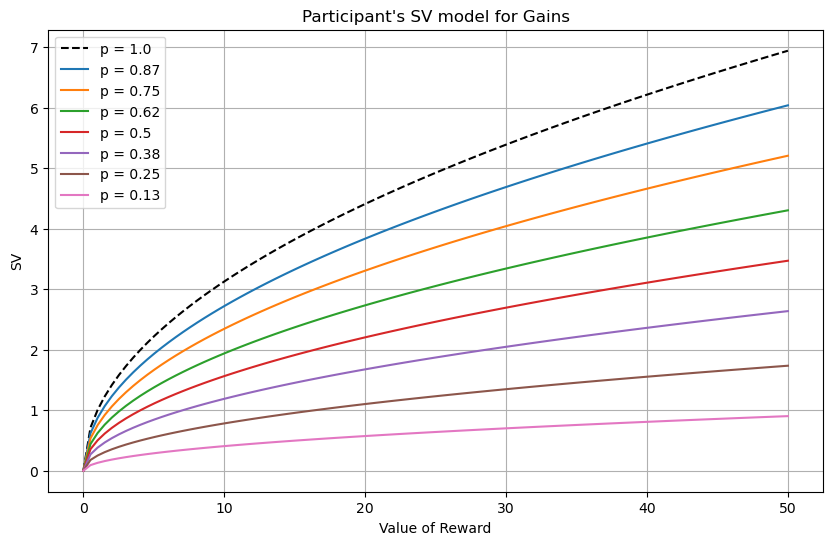

In [153]:
calculate_sv_gains(alpha_pos, beta_pos)

# 2. Creating the choice set
From the Subjective Value formula, we can calculate new values:
# $SV = (p - \beta \cdot \frac{A}{2}) \cdot V^\alpha$ --->  $V = \left(\frac{SV}{p-\frac{\beta A}{2}}\right)^\frac{1}{\alpha}$






**For each probability level:**
- We want to make 3 trials around the point of subjective equality. 

- We want 2 extreme trials. 
  -  Winning $50 for each probability level
  -  Loosing $50 for each probability level
  - 

- We want 4 intermediate trials.  


In [154]:
#Create the extreme positive gains and losses

def get_extreme(p_options,trials='gains'):
    extr = {} #Create an empty dict
    V = Vmax
    if trials=='losses': #If trials are losses, assign them -50
        V = Vmin
    for p in p_options: #Iterate through the probability levels
        extr[p] = V #Assign them the 50 dollars value
    return extr

extrpos = get_extreme(p_options)
print('Gain trials with the maximum Reward: \n', extrpos)

extrneg = get_extreme(p_options,trials='losses')
print('\nLoss trials with the maximum loss: \n', extrneg)



Gain trials with the maximum Reward: 
 {0.87: 50.0, 0.75: 50.0, 0.62: 50.0, 0.5: 50.0, 0.38: 50.0, 0.25: 50.0, 0.13: 50.0}

Loss trials with the maximum loss: 
 {0.87: -50.0, 0.75: -50.0, 0.62: -50.0, 0.5: -50.0, 0.38: -50.0, 0.25: -50.0, 0.13: -50.0}


In [155]:
#From the dictionaries, we create DataFrames to work with

def get_extr_df(extr_dict,trials='gains'):
    df_app = pd.DataFrame(extr_dict.items(), columns=['p_reward', 'value_reward'])
    Extr_df = pd.concat([empty_df, df_app], ignore_index=True)
    category = 'Extr_pos'
    if trials=='losses':
        category = 'Extr_neg'
    Extr_df['category'] = category
    return Extr_df

#We define a function to calculate the SV of the trials given the 
#participant's alpha and beta

def append_SVreward(df,alpha,beta,trials='gains'):
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    df['SV_reward'] = (df['p_reward'] - beta*A/2)*Amp*(abs(df['value_reward']))**alpha
    return df

#We define a function to calculate the SV of the safe options of the trials given the 
#participant's alpha and beta

def append_Vsafe(df,alpha,beta,trials='gains'): 
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    df['SV_New_Safe'] = 0.5*df['SV_reward']
    df['value_lott_SE'] = Amp*(abs(df['SV_New_Safe']) / (df['p_reward']-beta*A/2)) ** (1 / alpha)
    df['value_safe'] = Amp*(abs(df['SV_New_Safe'])) ** (1 / alpha)
    return df

#Define the data frames
df_pos = get_extr_df(extrpos)
df_neg = get_extr_df(extrneg,trials='losses')

#Add the SV of reward and safe trials
df_pos = append_SVreward(df_pos,alpha_pos,beta_pos)
df_neg = append_SVreward(df_neg,alpha_neg,beta_neg,trials='losses')

df_pos = append_Vsafe(df_pos,alpha_pos,beta_pos)
df_neg = append_Vsafe(df_neg,alpha_neg,beta_neg,trials='losses')

df_pos

,category,p_reward,value_reward,SV_reward,SV_New_Safe,value_lott_SE,value_safe
0,Extr_pos,0.87,50.0,6.040315,3.020158,12.337473,9.313711
1,Extr_pos,0.75,50.0,5.207169,2.603584,12.337473,6.902235
2,Extr_pos,0.62,50.0,4.304593,2.152296,12.337473,4.699912
3,Extr_pos,0.50,50.0,3.471446,1.735723,12.337473,3.044265
4,Extr_pos,0.38,50.0,2.638299,1.319149,12.337473,1.749280
5,Extr_pos,0.25,50.0,1.735723,0.867861,12.337473,0.751171
6,Extr_pos,0.13,50.0,0.902576,0.451288,12.337473,0.200624


In [156]:
df_neg

,category,p_reward,value_reward,SV_reward,SV_New_Safe,value_lott_SE,value_safe
0,Extr_neg,0.87,-50.0,-6.158501,-3.079251,-12.509602,-9.469978
1,Extr_neg,0.75,-50.0,-5.309053,-2.654526,-12.509602,-7.038894
2,Extr_neg,0.62,-50.0,-4.388817,-2.194408,-12.509602,-4.811238
3,Extr_neg,0.50,-50.0,-3.539368,-1.769684,-12.509602,-3.129803
4,Extr_neg,0.38,-50.0,-2.689920,-1.344960,-12.509602,-1.808324
5,Extr_neg,0.25,-50.0,-1.769684,-0.884842,-12.509602,-0.783052
6,Extr_neg,0.13,-50.0,-0.920236,-0.460118,-12.509602,-0.211891


In [157]:
df_safe_pos = df_pos[['p_reward','SV_New_Safe','value_lott_SE','value_safe']].copy()
df_safe_pos

,p_reward,SV_New_Safe,value_lott_SE,value_safe
0,0.87,3.020158,12.337473,9.313711
1,0.75,2.603584,12.337473,6.902235
2,0.62,2.152296,12.337473,4.699912
3,0.50,1.735723,12.337473,3.044265
4,0.38,1.319149,12.337473,1.749280
5,0.25,0.867861,12.337473,0.751171
6,0.13,0.451288,12.337473,0.200624


In [158]:
df_SE_pos = df_pos[['category','p_reward','value_lott_SE']].copy()
df_SE_pos['category'] = 'SE_pos'
df_SE_pos = df_SE_pos.rename(columns={'value_lott_SE':'value_reward'})
df_SE_pos = append_SVreward(df_SE_pos,alpha_pos,beta_pos)
#df_SE_pos['value_safe'] = df_pos['value_safe_SE']
#df_SE_pos = df_SE_pos.drop(columns=['SV_New_Safe','value_lott_SE'])
df_SE_pos

,category,p_reward,value_reward,SV_reward
0,SE_pos,0.87,12.337473,3.020158
1,SE_pos,0.75,12.337473,2.603584
2,SE_pos,0.62,12.337473,2.152296
3,SE_pos,0.50,12.337473,1.735723
4,SE_pos,0.38,12.337473,1.319149
5,SE_pos,0.25,12.337473,0.867861
6,SE_pos,0.13,12.337473,0.451288


In [159]:
#Centered around SE
df_cent_pos= df_SE_pos[['category', 'p_reward', 'value_reward']].copy()

df_cent_pos['category'] = 'Cent_SE_pos'
df_cent_pos = append_SVreward(df_cent_pos,alpha_pos,beta_pos)
df_cent_pos = pd.merge(df_cent_pos,df_safe_pos,on='p_reward')

#New dfs
df_adjusted_pos = df_cent_pos.copy()
df_adjusted_pos['value_reward'] = df_adjusted_pos['value_reward'] +2.0

df_adjusted_neg = df_cent_pos.copy()
df_adjusted_neg['value_reward'] = df_adjusted_neg['value_reward'] - 2.0
df_cent_pos = pd.concat([df_cent_pos, df_adjusted_pos, df_adjusted_neg], ignore_index=True)

#Centered around SE DF
df_cent_pos = append_SVreward(df_cent_pos,alpha_pos,beta_pos)
df_cent_pos

,category,p_reward,value_reward,SV_reward,SV_New_Safe,value_lott_SE,value_safe
0,Cent_SE_pos,0.87,12.337473,3.020158,3.020158,12.337473,9.313711
1,Cent_SE_pos,0.75,12.337473,2.603584,2.603584,12.337473,6.902235
2,Cent_SE_pos,0.62,12.337473,2.152296,2.152296,12.337473,4.699912
3,Cent_SE_pos,0.50,12.337473,1.735723,1.735723,12.337473,3.044265
4,Cent_SE_pos,0.38,12.337473,1.319149,1.319149,12.337473,1.749280
5,Cent_SE_pos,0.25,12.337473,0.867861,0.867861,12.337473,0.751171
6,Cent_SE_pos,0.13,12.337473,0.451288,0.451288,12.337473,0.200624
7,Cent_SE_pos,0.87,14.337473,3.253477,3.020158,12.337473,9.313711
8,Cent_SE_pos,0.75,14.337473,2.804721,2.603584,12.337473,6.902235
9,Cent_SE_pos,0.62,14.337473,2.318570,2.152296,12.337473,4.699912


In [160]:
df_int_temp = df_pos.copy()
df_int_temp['category'] = 'Int_pos'
df_int_temp


,category,p_reward,value_reward,SV_reward,SV_New_Safe,value_lott_SE,value_safe
0,Int_pos,0.87,50.0,6.040315,3.020158,12.337473,9.313711
1,Int_pos,0.75,50.0,5.207169,2.603584,12.337473,6.902235
2,Int_pos,0.62,50.0,4.304593,2.152296,12.337473,4.699912
3,Int_pos,0.50,50.0,3.471446,1.735723,12.337473,3.044265
4,Int_pos,0.38,50.0,2.638299,1.319149,12.337473,1.749280
5,Int_pos,0.25,50.0,1.735723,0.867861,12.337473,0.751171
6,Int_pos,0.13,50.0,0.902576,0.451288,12.337473,0.200624


In [161]:
def get_interm(df,df_safe_pos,beta,alpha,num_steps=2, trials = 'gains'):
    
    Amp = 1.0
    if trials == 'losses':
        Amp = -1.0
    dfreturn = pd.DataFrame([], columns = list(df))
    df['SVrange'] = df['SV_reward'] - df['SV_New_Safe']
    df['SVstep'] =  df['SVrange']/(num_steps+1)
    list_x = [i for i in range(-num_steps-1,num_steps+1) if i != 0]
    
    for x in list_x:
        dfint = df[['category', 'p_reward']].copy()
        if x == -num_steps-1:
            dfint['category'] = 'Zero_Reward'
        dfint['SV_reward'] = df['SV_New_Safe'] + x*df['SVstep']
        dfint['value_reward'] = Amp*(abs(dfint['SV_reward']) / (dfint['p_reward']-beta*A/2)) ** (1 / alpha) 
        dfint = pd.merge(dfint,df_safe_pos,on='p_reward')
        dfreturn= pd.concat([dfreturn,dfint],ignore_index=True)

    return dfreturn

df_int_pos = get_interm(df_int_temp, df_safe_pos, beta_pos,alpha_pos, num_steps=2)
df_int_pos

,category,p_reward,value_reward,SV_reward,SV_New_Safe,value_lott_SE,value_safe
0,Zero_Reward,0.87,1.340202e-31,4.440892e-16,3.020158,12.337473,9.313711
1,Zero_Reward,0.75,0.000000e+00,0.000000e+00,2.603584,12.337473,6.902235
2,Zero_Reward,0.62,0.000000e+00,0.000000e+00,2.152296,12.337473,4.699912
3,Zero_Reward,0.50,0.000000e+00,0.000000e+00,1.735723,12.337473,3.044265
4,Zero_Reward,0.38,0.000000e+00,0.000000e+00,1.319149,12.337473,1.749280
5,Zero_Reward,0.25,0.000000e+00,0.000000e+00,0.867861,12.337473,0.751171
6,Zero_Reward,0.13,0.000000e+00,0.000000e+00,0.451288,12.337473,0.200624
7,Int_pos,0.87,1.342688e+00,1.006719e+00,3.020158,12.337473,9.313711
8,Int_pos,0.75,1.342688e+00,8.678614e-01,2.603584,12.337473,6.902235
9,Int_pos,0.62,1.342688e+00,7.174321e-01,2.152296,12.337473,4.699912


# concat three dataframes
CentTrials trials centered around Subjective Equality
ExtrPos trials in the extreme where value reward is $50
IntPor trials in between along range (SE and SVmax)

In [162]:
df_Trials_gains = pd.concat([df_pos,df_int_pos,df_cent_pos],ignore_index=True)

#df_Trials_gains['SV_Safe'] = df_Trials_gains['Value_Safe']**alpha_pos
df_Trials_gains['deltaSV'] = df_Trials_gains['SV_reward'] - df_Trials_gains['SV_New_Safe']
df_Trials_gains = df_Trials_gains.round(2)



In [163]:
crdm_trials_gains = 'csv/crdm_trials_gains.csv'

# Save the filtered DataFrame to a new CSV file
df_Trials_gains.to_csv(crdm_trials_gains, index=False)

print(f"CSV file filtered successfully.")
pd.read_csv(crdm_trials_gains)

CSV file filtered successfully.


,category,p_reward,value_reward,SV_reward,SV_New_Safe,value_lott_SE,value_safe,deltaSV
0,Extr_pos,0.87,50.00,6.04,3.02,12.34,9.31,3.02
1,Extr_pos,0.75,50.00,5.21,2.60,12.34,6.90,2.60
2,Extr_pos,0.62,50.00,4.30,2.15,12.34,4.70,2.15
3,Extr_pos,0.50,50.00,3.47,1.74,12.34,3.04,1.74
4,Extr_pos,0.38,50.00,2.64,1.32,12.34,1.75,1.32
...,...,...,...,...,...,...,...,...
58,Cent_SE_pos,0.62,10.34,1.97,2.15,12.34,4.70,-0.18
59,Cent_SE_pos,0.50,10.34,1.59,1.74,12.34,3.04,-0.15
60,Cent_SE_pos,0.38,10.34,1.21,1.32,12.34,1.75,-0.11
61,Cent_SE_pos,0.25,10.34,0.80,0.87,12.34,0.75,-0.07


# Visualization

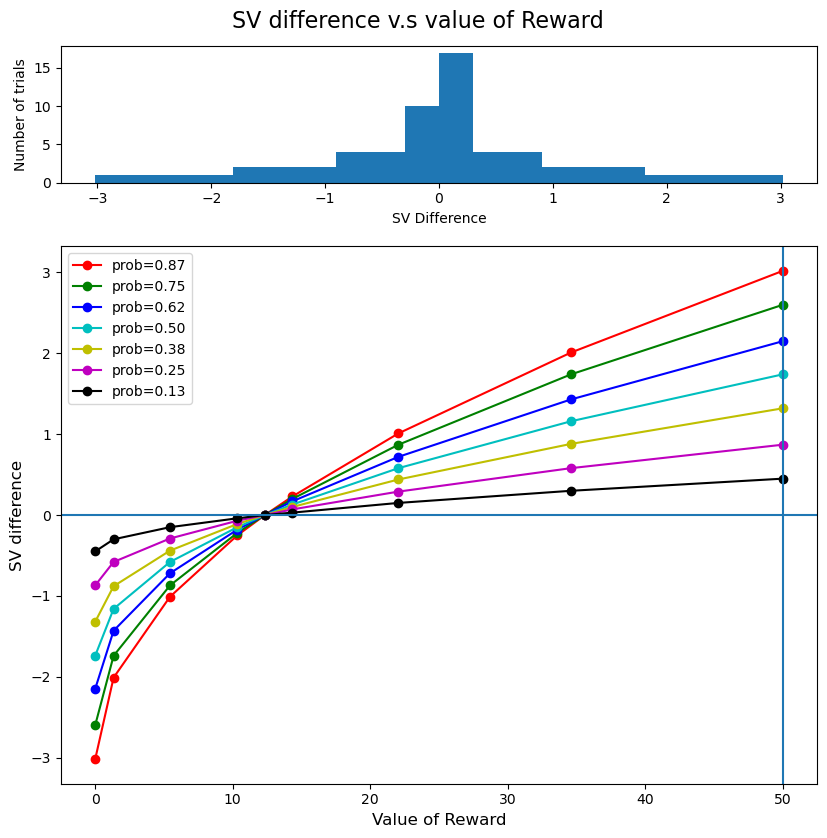

In [164]:
from matplotlib.gridspec import GridSpec
import sys

def scatter_hist(x, y, ax, ax_histy,xlabel='',ylabel='',title=''): #This functions creates a scatter plot with histograms at its sides
	#ax.scatter(x, y)
	ax.set_xlabel(xlabel,fontsize=12) #Creates the subplots
	ax.set_ylabel(ylabel,fontsize=12)
	plt.suptitle(title,fontsize=16, ha='center')
	#ax_histx.hist(x,bins=20)
	ax_histy.hist(y, bins=20)
	ax_histy.set_xlabel('SV Difference')
	ax_histy.set_ylabel('Number of trials')
	plt.tight_layout()


def setup_fig_ax():  #Setting the axis

	fig = plt.figure(figsize=(8.5,8.5))
	gs = GridSpec(4, 3)

	ax = fig.add_subplot(gs[1:4, 0:3])
	ax_histy = fig.add_subplot(gs[0,0:3])
	#ax_histx = fig.add_subplot(gs[1:4, 3])
	#ax_histx.tick_params(axis="x", labelbottom=False)
	ax_histy.tick_params(axis="y")
 	
	#Adjust spacing around subplots
	#plt.subplots_adjust(top=1.4, bottom=0.15, left=0.15, right=0.9)
	
	return ax, ax_histy

def plot_scatter_hist(df):

	# delta SV v.s value_reward
	x,y = df['value_reward'],df['deltaSV'] 
	ax,ax_histy = setup_fig_ax()

	scatter_hist(x,y,ax,ax_histy,  
		xlabel='Value of Reward',
		ylabel= 'SV difference',
		title= 'SV difference v.s value of Reward')

	colors = ['r','g','b','c','y','m','k']
	df = df.sort_values('value_reward')

	for i,p in enumerate(reversed(sorted(df['p_reward'].unique()))): #A scatter plot for each probability level
		x,y = df.loc[df['p_reward']==p,'value_reward'], df.loc[df['p_reward']==p,'deltaSV']
		ax.plot(x, y,'{}o-'.format(colors[i]),label='prob={0:0.2f}'.format(p)) #The plot conecting prob levels

	# ax.plot([50],[],'r-')
	ax.axvline(x=50)
	# ax.plot([-50,-50],[-10,10],'r-')
	ax.axhline(y=0)
	# ax.plot([0,50],[0,0],'k--')
	ax.legend(loc="upper left")

plot_scatter_hist(df_Trials_gains)



In [165]:
def plot_scatter_hist_flipped(df):

	# delta SV v.s value_reward
	y,x = df['value_reward'],df['deltaSV'] 
	ax,ax_histx,ax_histy = setup_fig_ax()

	scatter_hist(x,y,ax,ax_histx,ax_histy, 
		xlabel='SV difference',
		ylabel= 'Value of Reward',
		title= 'Value of Reward v.s SV difference')

	colors = ['r','g','b','c','y','m','k']
	df = df.sort_values('value_reward')
	print(df['p_reward'].unique())

	for i,p in enumerate(reversed(sorted(df['p_reward'].unique()))):
		print('index {} with p_reward is {}'.format(i,p))
		x,y = df.loc[df['p_reward']==p,'value_reward'], df.loc[df['p_reward']==p,'deltaSV']
		ax.plot(y,x,'{}o-'.format(colors[i]),label='prob={0:0.2f}'.format(p))

	# ax.plot([50],[],'r-')
	ax.axhline(y=50)
	# ax.plot([-50,-50],[-10,10],'r-')
	ax.axvline(x=0)
	# ax.plot([0,50],[0,0],'k--')
	ax.legend(loc="upper left")

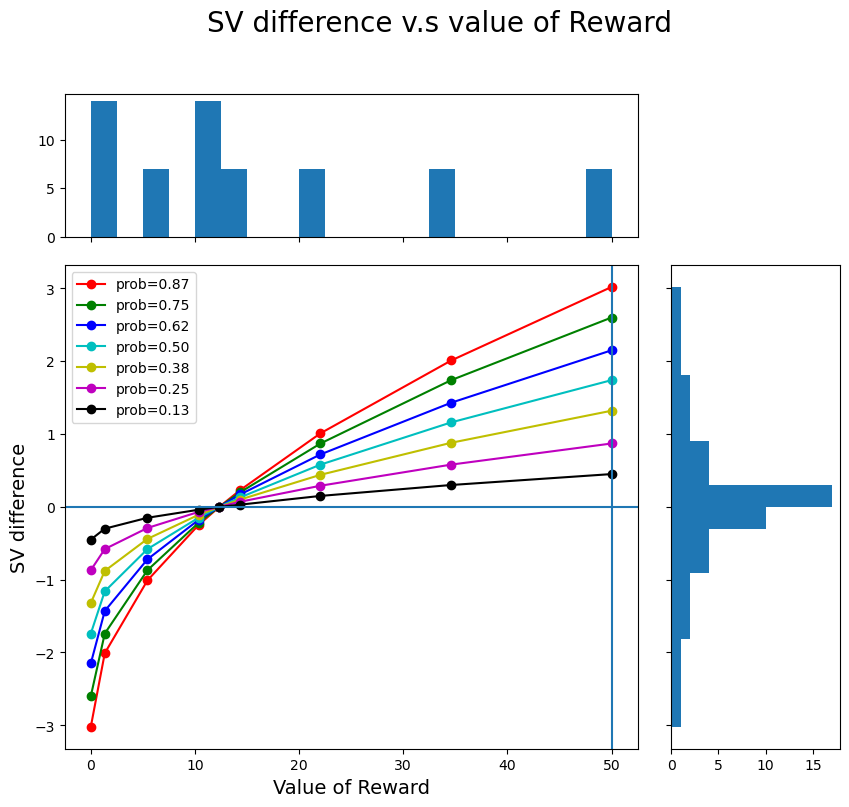

In [166]:
#Original Scatter Hist
def scatter_hist(x, y, ax, ax_histx, ax_histy,xlabel='',ylabel='',title=''):
	#ax.scatter(x, y)
	ax.set_xlabel(xlabel,fontsize=14) #Creates the subplots
	ax.set_ylabel(ylabel,fontsize=14)
	plt.suptitle(title,fontsize=20)
	ax_histx.hist(x,bins=20)
	ax_histy.hist(y, bins=20,orientation = 'horizontal')


def setup_fig_ax():  #Setting the axis

	fig = plt.figure(figsize=(10,8.5))
	gs = GridSpec(4, 4)

	ax = fig.add_subplot(gs[1:4, 0:3])
	ax_histx = fig.add_subplot(gs[0,0:3])
	ax_histy = fig.add_subplot(gs[1:4, 3])
	ax_histx.tick_params(axis="x", labelbottom=False)
	ax_histy.tick_params(axis="y", labelleft=False)

	return ax,ax_histx,ax_histy

def plot_scatter_hist(df):

	# delta SV v.s value_reward
	x,y = df['value_reward'],df['deltaSV'] 
	ax,ax_histx,ax_histy = setup_fig_ax()

	scatter_hist(x,y,ax,ax_histx,ax_histy,  
		xlabel='Value of Reward',
		ylabel= 'SV difference',
		title= 'SV difference v.s value of Reward')

	colors = ['r','g','b','c','y','m','k']
	df = df.sort_values('value_reward')

	for i,p in enumerate(reversed(sorted(df['p_reward'].unique()))): #A scatter plot for each probability level
		x,y = df.loc[df['p_reward']==p,'value_reward'], df.loc[df['p_reward']==p,'deltaSV']
		ax.plot(x, y,'{}o-'.format(colors[i]),label='prob={0:0.2f}'.format(p)) #The plot conecting prob levels

	# ax.plot([50],[],'r-')
	ax.axvline(x=50)
	# ax.plot([-50,-50],[-10,10],'r-')
	ax.axhline(y=0)
	# ax.plot([0,50],[0,0],'k--')
	ax.legend(loc="upper left")

plot_scatter_hist(df_Trials_gains)

[0.5  0.87 0.75 0.62 0.13 0.38 0.25]
index 0 with p_reward is 0.87
index 1 with p_reward is 0.75
index 2 with p_reward is 0.62
index 3 with p_reward is 0.5
index 4 with p_reward is 0.38
index 5 with p_reward is 0.25
index 6 with p_reward is 0.13


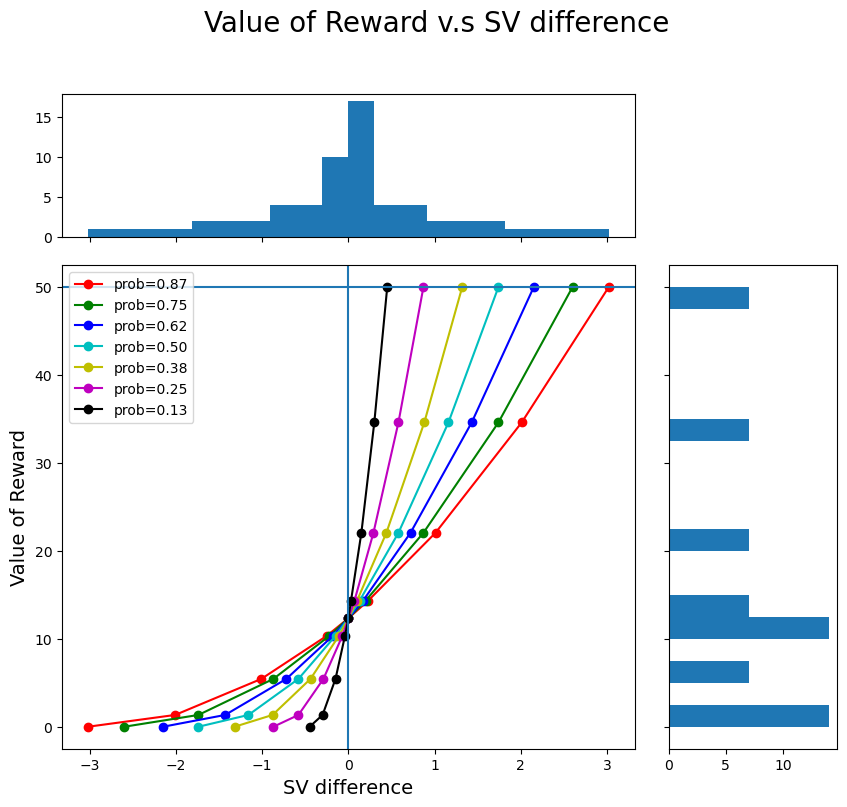

In [167]:
plot_scatter_hist_flipped(df_Trials_gains)

## It's not much but it's honest work
![python](https://plantillasdememes.com/img/plantillas/no-es-mucho-pero-es-trabajo-honesto01569991155.jpg)